In [21]:
import statsmodels.api as sm
from pmdarima import auto_arima
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import warnings
from scipy import stats
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import timeseriesmetrics as tss
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from pmdarima import model_selection
import time

import timeseriesmetrics as mt

warnings.filterwarnings('ignore')

# DEFININDO O NOSSO PATH COM OS DADOS
DATA_PATH_TSLA = '../bds/TSLA.csv'

In [22]:
import auxiliar as ax
from sklearn.tree import DecisionTreeRegressor
from skopt.space import Real, Integer
from skopt import gp_minimize
from sklearn.metrics import root_mean_squared_error

In [23]:
TESLA = pd.read_csv(DATA_PATH_TSLA ,sep=',',usecols=[0,4])

significantLags: [1, 5, 8, 10, 19, 25, 45, 47, 50, 57, 64, 68]
          Date       Close   (Close-1)   (Close-5)   (Close-8)  (Close-10)  \
68  2020-12-08  216.626663  213.919998  194.919998  191.333328  173.949997   
69  2020-12-09  201.493332  216.626663  189.606674  195.253326  185.126663   

    (Close-19)  (Close-25)  (Close-45)  (Close-47)  (Close-50)  (Close-57)  \
68  136.786667  133.503326  141.893326  149.386673  140.399994  141.143326   
69  139.043335  141.300003  137.993332  138.363327  139.690002  147.383331   

    (Close-64)  (Close-68)  
68   110.07000  158.350006  
69   122.09333  149.123337  


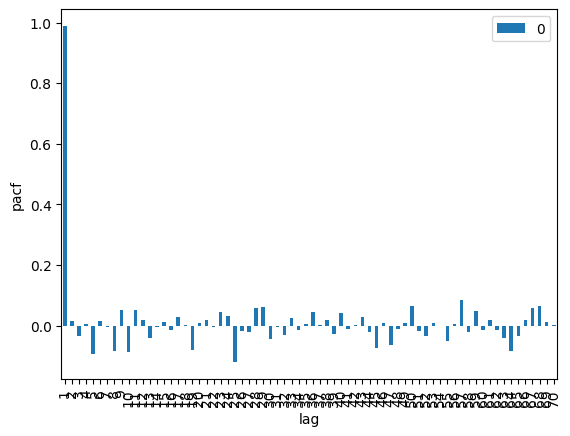

In [24]:
tesla_significantLags = ax.getSignificantLags(y=TESLA['Close'], nLags = 70, alpha=0.05)

TM_tesla = ax.appendLagVariables(yNm='Close', significantLags = tesla_significantLags, df = TESLA, dropna=True)

In [25]:
df_tesla = TM_tesla.dropna()
# Separar features e target
X = df_tesla.drop('Close', axis=1)
X = X.drop('Date', axis=1)
X = X.iloc[1:]
y = np.roll(df_tesla['Close'], 1)[1:]
y_aux = df_tesla['Close'].iloc[1:]


In [26]:
# Dividir os dados em treino e teste
X_train_tesla, X_test_tesla, y_train_tesla, y_test_tesla = train_test_split(X, y, test_size=0.2, shuffle=False)

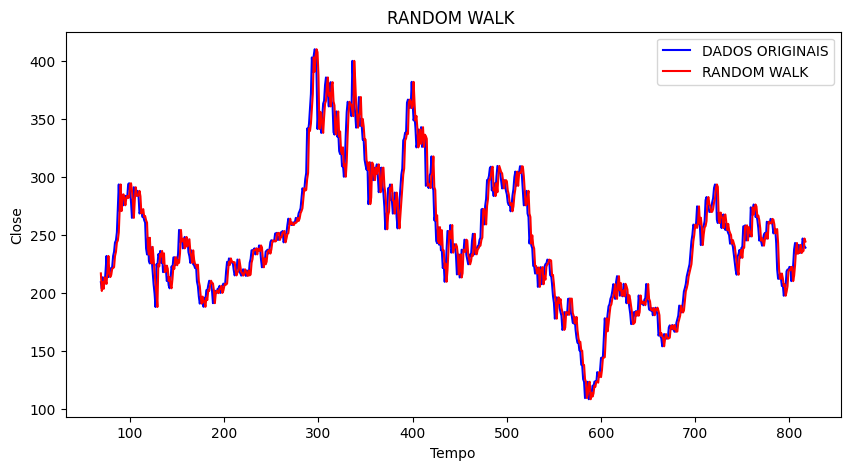

In [27]:
plt.figure(figsize=(10, 5))
plt.plot(X_train_tesla.index, y_aux[1:len(y_train_tesla)+1], label='DADOS ORIGINAIS', color='blue')
plt.plot(X_train_tesla.index, y_train_tesla, label='RANDOM WALK', color='red')
plt.title(f'RANDOM WALK ')
plt.xlabel('Tempo')
plt.ylabel('Close')
plt.legend()
plt.show()
   

# ÁRVORE DE DECISÃO

## Bayesian optimization

In [28]:
space = [
    Integer(1, 50, name='max_depth'),                # profundidade máxima da árvore
    Integer(2, 50, name='min_samples_split'),         # mínimo de amostras para dividir um nó
    Integer(1, 50, name='min_samples_leaf'),           # mínimo de amostras em um nó folha            
    Real(0.1, 1.0, name='max_features'),                # fração de características a serem consideradas
]

In [29]:
erro_random = y_aux.iloc[:len(y_train_tesla)] - y_train_tesla

In [30]:
X = X_train_tesla            #X_train_tesla.iloc[2:]
y = erro_random           #erro_random_walk.iloc[1:]

In [31]:
def objective1(params):
    max_depth, min_samples_split, min_samples_leaf, max_features  = params
    model = DecisionTreeRegressor(
            max_depth=int(max_depth),
            min_samples_split=int(min_samples_split),
            min_samples_leaf=int(min_samples_leaf),
            max_features=max_features
    )
    model.fit(X, y)

    # Fazer previsões
    y_pred = model.predict(X)
    return mean_squared_error(y, y_pred)

In [32]:
window_size=60
test_size=20
def objective2(params):
    results = ax.sliding_window_cross_validation(X, y, window_size, test_size, params)
    return results['mse']

In [33]:
train_size=60
test_size=20
def objective3(params):
    results = ax.rolling_window_cross_validation(X, y, train_size, test_size, params)
    return results['mse']

In [34]:
train_size=60
test_size=20
buffer_size = 12
def objective4(params):
    results = ax.blocked_cross_validation(X, y, train_size, test_size, buffer_size, params)
    return results['mse']

In [35]:
list_function_objective = [objective1, objective2, objective3, objective4]
tempo = []
resultados = []
for func in list_function_objective:
    start_time = time.time()
    #resultados.append(gp_minimize(func, space, n_calls=50, random_state=42))
    end_time = time.time()
    execution_time = end_time - start_time
    tempo.append(execution_time)

In [36]:
bests_models = []
pred_with_bests_models = []

best_max_depth_list = []
best_min_samples_split_list = []
best_min_samples_leaf_list = []
best_max_features_list = []

mae_of_train = []

for parms in resultados:
    best_max_depth = int(parms.x[0])
    best_max_depth_list.append(best_max_depth)
    best_min_samples_split = int(parms.x[1])
    best_min_samples_split_list.append(best_min_samples_split)
    best_min_samples_leaf = int(parms.x[2])
    best_min_samples_leaf_list.append(best_min_samples_leaf)
    best_max_features = parms.x[3]
    best_max_features_list.append(best_max_features)

    best_model = DecisionTreeRegressor(
        max_depth=best_max_depth,
        min_samples_split=best_min_samples_split,
        min_samples_leaf=best_min_samples_leaf,
        max_features=best_max_features
    )
    best_model.fit(X, y)
    y_pred_train_aux = best_model.predict(X)
    mae_of_train.append(mean_squared_error(y, y_pred_train_aux))
    y_best_pred = best_model.predict(X_test_tesla)
    pred_with_bests_models.append(y_best_pred)
    bests_models.append(best_model)


In [37]:
previsoes_completo = []
for y_pred in pred_with_bests_models:
    previsoes_completo.append(y_test_tesla + y_pred)

## RandomizedSearchCV

### DESEMPENHO

In [38]:
mae_of_pred_with_bm = []
for y_pred in previsoes_completo:
    mae_of_pred_with_bm.append(mean_squared_error(y_aux.iloc[len(y_train_tesla):], y_pred))

In [39]:
name_of_models = ['standard', 'proposed_SW', 'proposed_RW', 'proposed_B']

In [40]:
table_of_result = pd.DataFrame({
    'Nome': name_of_models,
    'best_max_depth': best_max_depth_list,
    'best_min_samples_split': best_min_samples_split_list,
    'best_min_samples_leaf': best_min_samples_leaf_list,
    'best_max_features': best_max_features_list,
    'MSE - Train': mae_of_train,
    'MSE - Test': mae_of_pred_with_bm,
    'Execution Time': tempo
})
table_of_result

ValueError: All arrays must be of the same length

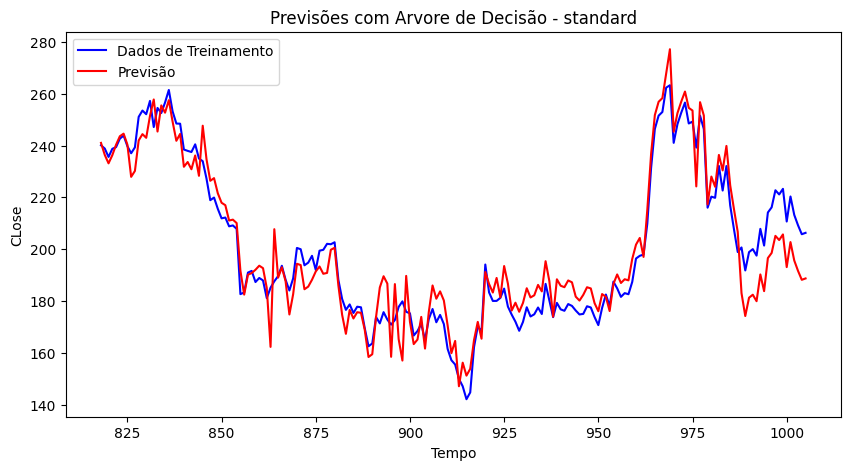

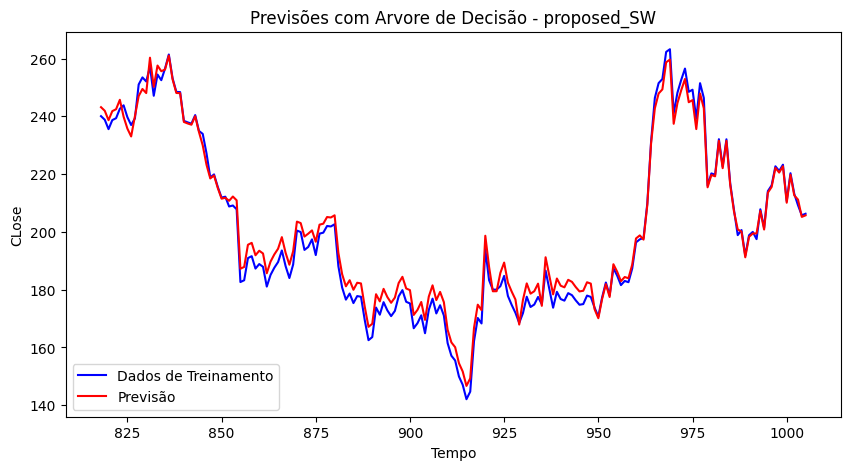

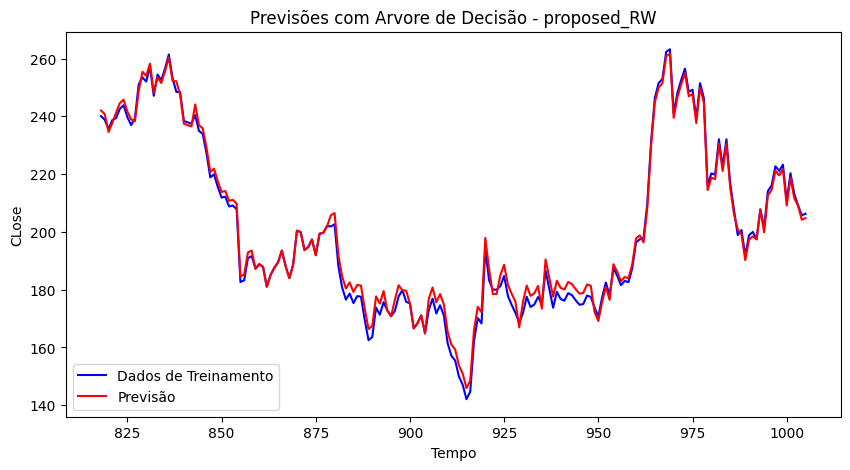

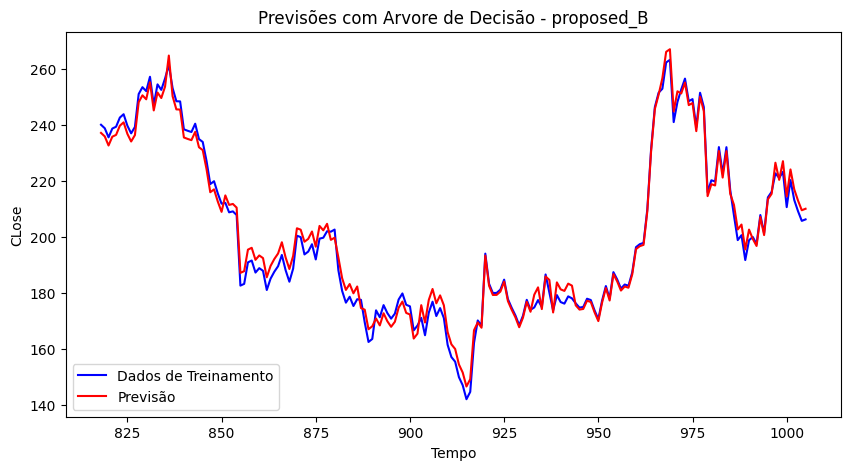

In [ ]:
aux = 0
x_index = X_test_tesla.index
for y_pred in previsoes_completo:
    plt.figure(figsize=(10, 5))
    plt.plot(x_index, y_test_tesla, label='Dados de Treinamento', color='blue')
    plt.plot(x_index, y_pred, label='Previsão', color='red')
    plt.title(f'Previsões com Arvore de Decisão - {name_of_models[aux]}')
    plt.xlabel('Tempo')
    plt.ylabel('CLose')
    plt.legend()
    plt.show()
    aux += 1

In [ ]:
indice = 0
for y_pred in previsoes_completo:
    print(f'MODELO: {name_of_models[indice]}')
    display(ax.calcular_metricas_regressao(y_aux.iloc[len(y_train_tesla):], y_pred))
    indice +=1

MODELO: standard


,Métrica,Valor
0,MAE,9.342429
1,MSE,139.660677
2,MAPE,0.047306
3,RMSE,11.817812
4,R²,0.842419
5,THEIL,2.796383
6,ARV,0.157581
7,WPOCID,0.550802


MODELO: proposed_SW


,Métrica,Valor
0,MAE,6.121920
1,MSE,61.861444
2,MAPE,0.031222
3,RMSE,7.865205
4,R²,0.930201
5,THEIL,1.236836
6,ARV,0.069799
7,WPOCID,0.518717


MODELO: proposed_RW


,Métrica,Valor
0,MAE,5.935513
1,MSE,59.393119
2,MAPE,0.030000
3,RMSE,7.706693
4,R²,0.932986
5,THEIL,1.188333
6,ARV,0.067014
7,WPOCID,0.524064


MODELO: proposed_B


,Métrica,Valor
0,MAE,5.882592
1,MSE,60.253525
2,MAPE,0.029695
3,RMSE,7.762314
4,R²,0.932015
5,THEIL,1.206362
6,ARV,0.067985
7,WPOCID,0.534759


# - Fran

In [ ]:
def func(x):
    return 2*x+np.log(x)+1

In [ ]:
x = []
y = []
for i in range(1,100):
    x.append(i)
    y_aux = func(i)
    y.append(y_aux)

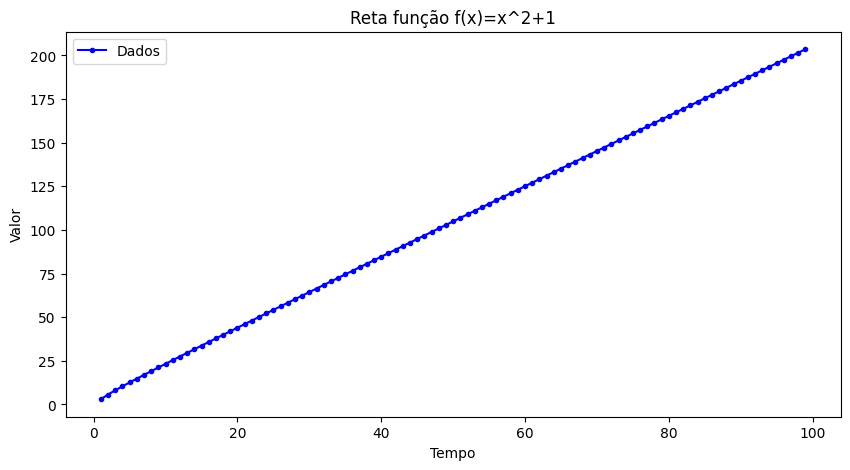

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(x, y, label='Dados', color='blue',marker='.')
plt.title(f'Reta função f(x)=x^2+1')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()
plt.show()

In [ ]:
tam_treino = int(len(x)*0.8)

In [ ]:
X_train = x[:tam_treino]
X_teste = x[tam_treino+1:]

y_train = y[:tam_treino]
y_teste = y[tam_treino+1:]

In [ ]:
model = LinearRegression(fit_intercept=True, positive= True)
model.fit(np.array(X_train).reshape(-1,1), np.array(y_train).reshape(-1,1))
ajuste_reta = model.predict(np.array(X_train).reshape(-1,1))

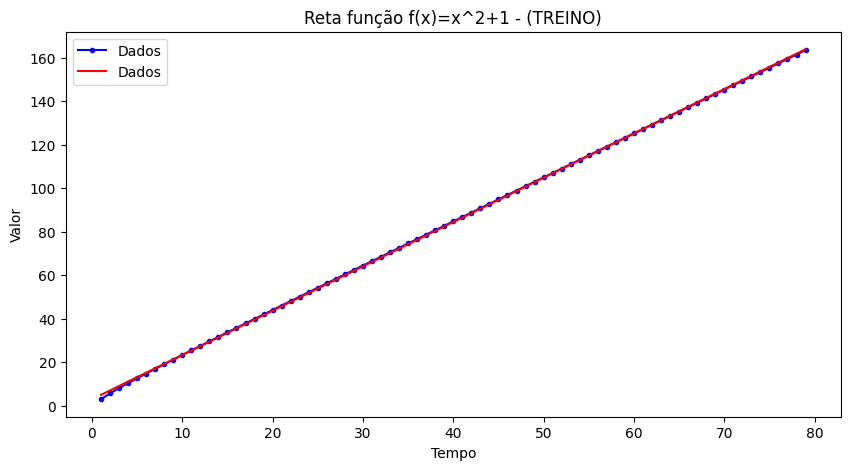

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(X_train, y_train, label='Dados', color='blue',marker='.')
plt.plot(X_train, ajuste_reta, label='Dados', color='red')
plt.title(f'Reta função f(x)=x^2+1 - (TREINO)')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()
plt.show()

In [ ]:
previsoes = model.predict(np.array(X_teste).reshape(-1,1))

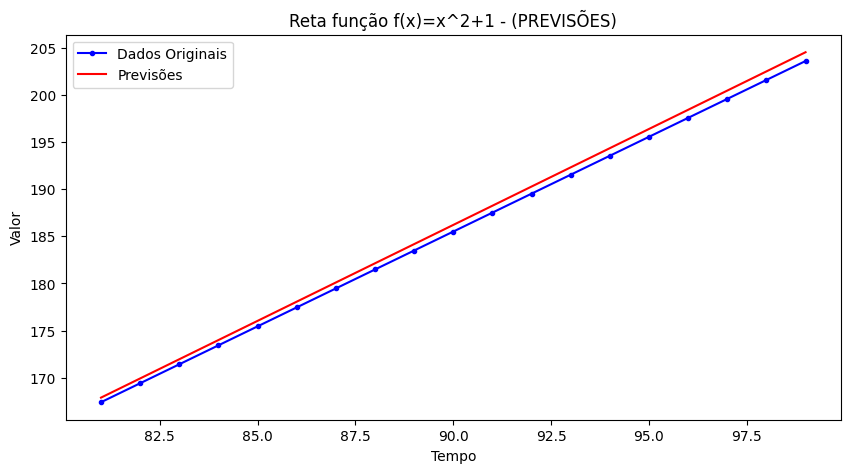

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(X_teste, y_teste, label='Dados Originais', color='blue',marker='.')
plt.plot(X_teste, previsoes, label='Previsões', color='red')
plt.title(f'Reta função f(x)=x^2+1 - (PREVISÕES)')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()
plt.show()

In [ ]:
root_mean_squared_error(y_teste, previsoes)

0.7204249044603932

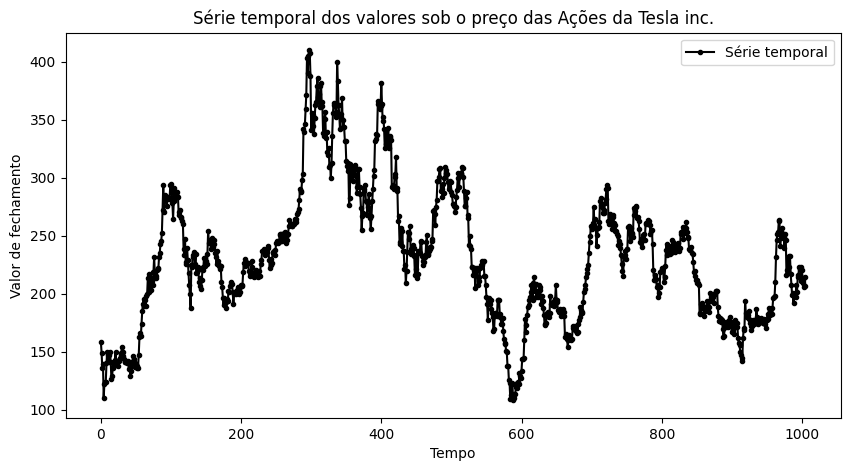

In [55]:
plt.figure(figsize=(10, 5))
plt.plot(TESLA['Date'].index, TESLA['Close'], label='Série temporal', color='black',marker='.')
plt.title(f'Série temporal dos valores sob o preço das Ações da Tesla inc.')
plt.xlabel('Tempo')
plt.ylabel('Valor de fechamento')
plt.legend()
plt.show()